# Classification 3. EPAM DS course 2022

# Dataset

This dataset contains user transitions between pages. The goal of this challenge is to recognize one user amongst all others. The dataset consists of user sessions, each session is a sequence of transitions between pages. A sequence can be one to ten pages long.

    train.csv - contains webpages, timestamps, and targets for each train session.
    test.csv - contains webpages, timestamps for each test session.
    id_map.parquet - webpages id to url map


# Imports

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip3 install pandas_profiling --upgrade
import pandas_profiling
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choice, randint
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## scikit-learn

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, \
  RandomizedSearchCV, GridSearchCV, cross_validate, KFold, RepeatedStratifiedKFold, \
  cross_val_score
from sklearn.base import clone

from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, \
  CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, \
  OneHotEncoder, LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import make_scorer, accuracy_score, precision_score, \
  recall_score, f1_score, precision_recall_curve, classification_report, roc_auc_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.ensemble import StackingClassifier


# Read Data

In [6]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
time_cols = ['time' + str(i) for i in range(1,11)]

In [8]:
link = 'https://drive.google.com/file/d/1WgtNzqAtqGvsW_6WjwrfEy6i4PRr8RtJ/view'

id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Classification3_HW_id_map.parquet')

url_map = pd.read_parquet('Classification3_HW_id_map.parquet')
url_map.set_index('id', inplace=True)
url_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48371 entries, 326127 to 564482
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   webpage  48371 non-null  object
dtypes: object(1)
memory usage: 755.8+ KB


In [9]:
link = 'https://drive.google.com/file/d/1Z-SvPTO8GvT4aDR0pZMi9THMRMT8KGzq/view'

id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Classification3_HW_train.csv')

df = pd.read_csv('Classification3_HW_train.csv', parse_dates=time_cols, \
                 index_col='session_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159969 entries, 0 to 159968
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   webpage1   159969 non-null  int64         
 1   time1      159969 non-null  datetime64[ns]
 2   webpage2   157990 non-null  float64       
 3   time2      157990 non-null  datetime64[ns]
 4   webpage3   156066 non-null  float64       
 5   time3      156066 non-null  datetime64[ns]
 6   webpage4   154402 non-null  float64       
 7   time4      154402 non-null  datetime64[ns]
 8   webpage5   152841 non-null  float64       
 9   time5      152841 non-null  datetime64[ns]
 10  webpage6   151324 non-null  float64       
 11  time6      151324 non-null  datetime64[ns]
 12  webpage7   149912 non-null  float64       
 13  time7      149912 non-null  datetime64[ns]
 14  webpage8   148574 non-null  float64       
 15  time8      148574 non-null  datetime64[ns]
 16  webpage9   147160 no

In [10]:
link = 'https://drive.google.com/file/d/1zE71-35wEqf1aK52DP2LgK32e2BLsEqu/view'

id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Classification3_HW_test.csv')

df_sub = pd.read_csv('Classification3_HW_test.csv', parse_dates=time_cols, \
                 index_col='session_id')
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93338 entries, 0 to 93337
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   webpage1   93338 non-null  int64         
 1   time1      93338 non-null  datetime64[ns]
 2   webpage2   91859 non-null  float64       
 3   time2      91859 non-null  datetime64[ns]
 4   webpage3   90606 non-null  float64       
 5   time3      90606 non-null  datetime64[ns]
 6   webpage4   89674 non-null  float64       
 7   time4      89674 non-null  datetime64[ns]
 8   webpage5   88744 non-null  float64       
 9   time5      88744 non-null  datetime64[ns]
 10  webpage6   87929 non-null  float64       
 11  time6      87929 non-null  datetime64[ns]
 12  webpage7   87143 non-null  float64       
 13  time7      87143 non-null  datetime64[ns]
 14  webpage8   86409 non-null  float64       
 15  time8      86409 non-null  datetime64[ns]
 16  webpage9   85685 non-null  float64      

In [11]:
df.head()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
0,9486,2019-02-20 05:57:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,2019-02-22 07:14:51,50150.0,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,2018-12-16 12:35:19,659.0,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,2019-02-13 12:41:05,425.0,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,2018-04-12 06:22:29,451.0,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0


# EDA

## Data type constrains

All data types look alright

## Uniqueness constrains

In [12]:
df.duplicated(keep=False).sum()

30

In [13]:
df.drop_duplicates(inplace=True)

## Missing data

We can see that sessions have different amount web pages per session, which is normal behaviour. Catboost wants all categories to be int type

In [14]:
webpage_cols = ['webpage'+str(i) for i in range(1,11)]
df[webpage_cols] = df[webpage_cols].fillna(0)
df[webpage_cols] = df[webpage_cols].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159953 entries, 0 to 159968
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   webpage1   159953 non-null  int64         
 1   time1      159953 non-null  datetime64[ns]
 2   webpage2   159953 non-null  int64         
 3   time2      157982 non-null  datetime64[ns]
 4   webpage3   159953 non-null  int64         
 5   time3      156058 non-null  datetime64[ns]
 6   webpage4   159953 non-null  int64         
 7   time4      154394 non-null  datetime64[ns]
 8   webpage5   159953 non-null  int64         
 9   time5      152833 non-null  datetime64[ns]
 10  webpage6   159953 non-null  int64         
 11  time6      151316 non-null  datetime64[ns]
 12  webpage7   159953 non-null  int64         
 13  time7      149904 non-null  datetime64[ns]
 14  webpage8   159953 non-null  int64         
 15  time8      148566 non-null  datetime64[ns]
 16  webpage9   159953 no

## Feature extraction

### Num

In [15]:
def extract_date_info(df):

  for i in range(1,10):
    df['time_delta'+str(i)] = (df['time'+str(i+1)] - df['time'+str(i)]).dt.total_seconds()
    df['time_delta'+str(i)].fillna(0)

  delta_cols = ['time_delta' + str(i) for i in range(1,10)]

  df['mean_delta'] = df[delta_cols].mean(axis=1)
  df['session_length'] = df[delta_cols].sum(axis=1)

  df['year'] = df['time1'].dt.year
  df['month'] = df['time1'].dt.month
  df['hour'] = df['time1'].dt.hour
  df['minute'] = df['time1'].dt.minute
  df['day_of_week'] = df['time1'].dt.dayofweek

  for i in range(1,11):  
    df.drop(['time'+str(i)], axis=1, inplace=True)

  return df

In [16]:
df = extract_date_info(df)
df_sub = extract_date_info(df_sub)
df.mean_delta.describe()

count    157982.000000
mean         20.103417
std          61.799965
min           0.000000
25%           0.777778
50%           3.111111
75%          12.888889
max        1800.000000
Name: mean_delta, dtype: float64

In [17]:
  df.session_length.describe()

count    159953.000000
mean        139.676011
std         300.334986
min           0.000000
25%           6.000000
50%          26.000000
75%         108.000000
max        1800.000000
Name: session_length, dtype: float64

In [18]:
  num_cols = df.select_dtypes('number').columns.to_list()
  num_cols.remove('target')
  print(num_cols)

['webpage1', 'webpage2', 'webpage3', 'webpage4', 'webpage5', 'webpage6', 'webpage7', 'webpage8', 'webpage9', 'webpage10', 'time_delta1', 'time_delta2', 'time_delta3', 'time_delta4', 'time_delta5', 'time_delta6', 'time_delta7', 'time_delta8', 'time_delta9', 'mean_delta', 'session_length', 'year', 'month', 'hour', 'minute', 'day_of_week']


### Text

In [19]:
def extract_url_info(df, url_map):
  df_merged = df.copy()
  df_merged['text'] = ' '
  df_merged['text2'] = ' '
  for i in range(1,11):
    df_merged = df_merged.merge(url_map, left_on='webpage'+str(i), how='left', \
                                right_index=True)
    df_merged.rename({'webpage':'url'+str(i)}, axis=1, inplace=True)
    df_merged['url'+str(i)] = df_merged['url'+str(i)].astype('string')
    df_merged['url'+str(i)] = df_merged['url'+str(i)].fillna('empty.empty')
    df_merged['r_url'+str(i)] = df_merged['url'+str(i)].str.replace('.', ' ', regex=True)

    df_merged['text'] = df_merged['text'] + df_merged['r_url'+str(i)] + ' '
    
    # I need to learn regexp at last ='(
    new_url=[]
    for url in df_merged['url'+str(i)]:
      lst  = url.split('.')
      lst = lst[-2] + lst[-1]
      new_url.append(lst)
    df_merged['lst'] = new_url
    df_merged['text2'] = df_merged['text2'] + df_merged['lst'] + ' '
  
  for i in range(1,11):  
    df_merged.drop(['r_url'+str(i)], axis=1, inplace=True)
    df_merged.drop(['url'+str(i)], axis=1, inplace=True)
      
  df_merged.drop(['lst'], axis=1, inplace=True)

  return df_merged


In [20]:
df = extract_url_info(df, url_map)
df_sub = extract_url_info(df_sub, url_map)

text_cols = ['url'+str(i) for i in range(1,11)]
text_cols.append('text')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159953 entries, 0 to 159968
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   webpage1        159953 non-null  int64  
 1   webpage2        159953 non-null  int64  
 2   webpage3        159953 non-null  int64  
 3   webpage4        159953 non-null  int64  
 4   webpage5        159953 non-null  int64  
 5   webpage6        159953 non-null  int64  
 6   webpage7        159953 non-null  int64  
 7   webpage8        159953 non-null  int64  
 8   webpage9        159953 non-null  int64  
 9   webpage10       159953 non-null  int64  
 10  target          159953 non-null  int64  
 11  time_delta1     157982 non-null  float64
 12  time_delta2     156058 non-null  float64
 13  time_delta3     154394 non-null  float64
 14  time_delta4     152833 non-null  float64
 15  time_delta5     151316 non-null  float64
 16  time_delta6     149904 non-null  float64
 17  time_delta

## Useless data and constans

In [21]:
(df.nunique()/len(df)).sort_values(ascending=False)

text              0.919101
text2             0.770145
webpage5          0.072365
webpage8          0.072365
webpage1          0.072302
webpage3          0.072284
webpage6          0.072240
webpage4          0.072234
webpage9          0.072140
webpage7          0.072115
webpage2          0.072090
webpage10         0.071959
mean_delta        0.034304
session_length    0.014404
time_delta2       0.007646
time_delta1       0.007440
time_delta3       0.007283
time_delta4       0.006527
time_delta5       0.006427
time_delta6       0.006333
time_delta8       0.006033
time_delta9       0.005989
time_delta7       0.005983
minute            0.000375
hour              0.000106
month             0.000075
day_of_week       0.000044
year              0.000013
target            0.000013
dtype: float64

In [22]:
df[num_cols].describe()

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,time_delta1,time_delta2,time_delta3,time_delta4,time_delta5,time_delta6,time_delta7,time_delta8,time_delta9,mean_delta,session_length,year,month,hour,minute,day_of_week
count,159953.000000,159953.000000,159953.000000,159953.000000,159953.000000,159953.000000,159953.000000,159953.000000,159953.000000,159953.000000,157982.000000,156058.000000,154394.000000,152833.000000,151316.000000,149904.000000,148566.000000,147152.000000,145848.000000,157982.000000,159953.000000,159953.000000,159953.000000,159953.000000,159953.000000,159953.000000
mean,44365.141254,44044.964327,43930.440254,43869.672104,43632.148500,43347.266241,43496.137991,43481.778823,43213.387789,43366.148394,18.801737,19.329275,18.244103,16.203981,15.780129,15.053528,14.484088,14.592727,14.521474,20.103417,139.676011,2018.533575,5.235888,8.282270,29.108494,2.273587
std,97171.568358,97205.756859,97045.476147,97121.463635,96748.392315,96461.286613,96803.861542,96792.397941,96564.769707,96900.576012,97.132919,106.694636,95.765064,82.387695,79.999075,75.893658,72.425958,73.806817,73.589832,61.799965,300.334986,0.498873,4.507326,3.209542,17.473621,1.995303
min,165.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,1.000000,3.000000,0.000000,0.000000
25%,828.000000,802.000000,737.000000,659.000000,633.000000,633.000000,607.000000,594.000000,581.000000,568.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777778,6.000000,2018.000000,2.000000,6.000000,14.000000,1.000000
50%,8160.000000,8160.000000,7562.000000,7562.000000,7562.000000,7510.000000,7419.000000,7211.000000,6756.000000,6366.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.111111,26.000000,2019.000000,2.000000,8.000000,29.000000,2.000000
75%,30845.000000,28908.000000,28284.000000,28245.000000,28167.000000,27153.000000,27166.000000,27166.000000,26789.000000,26594.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,12.888889,108.000000,2019.000000,11.000000,11.000000,44.000000,4.000000
max,540965.000000,540952.000000,540939.000000,540939.000000,540939.000000,540952.000000,540952.000000,540965.000000,540965.000000,540965.000000,1800.000000,1800.000000,1799.000000,1798.000000,1770.000000,1795.000000,1742.000000,1765.000000,1785.000000,1800.000000,1800.000000,2019.000000,12.000000,19.000000,59.000000,6.000000


Looks alright

## Target variable

In [23]:
df.target.value_counts()

0    158378
1      1575
Name: target, dtype: int64

In [24]:
df.target.value_counts(normalize=True)

0    0.990153
1    0.009847
Name: target, dtype: float64

Highly imbalanced dataset, need to use recall as a HP tuning metric, weights and/or SMOTE

## Independent variables

In [25]:
#profile = pandas_profiling.ProfileReport(df)
#profile.to_file('profile.html')

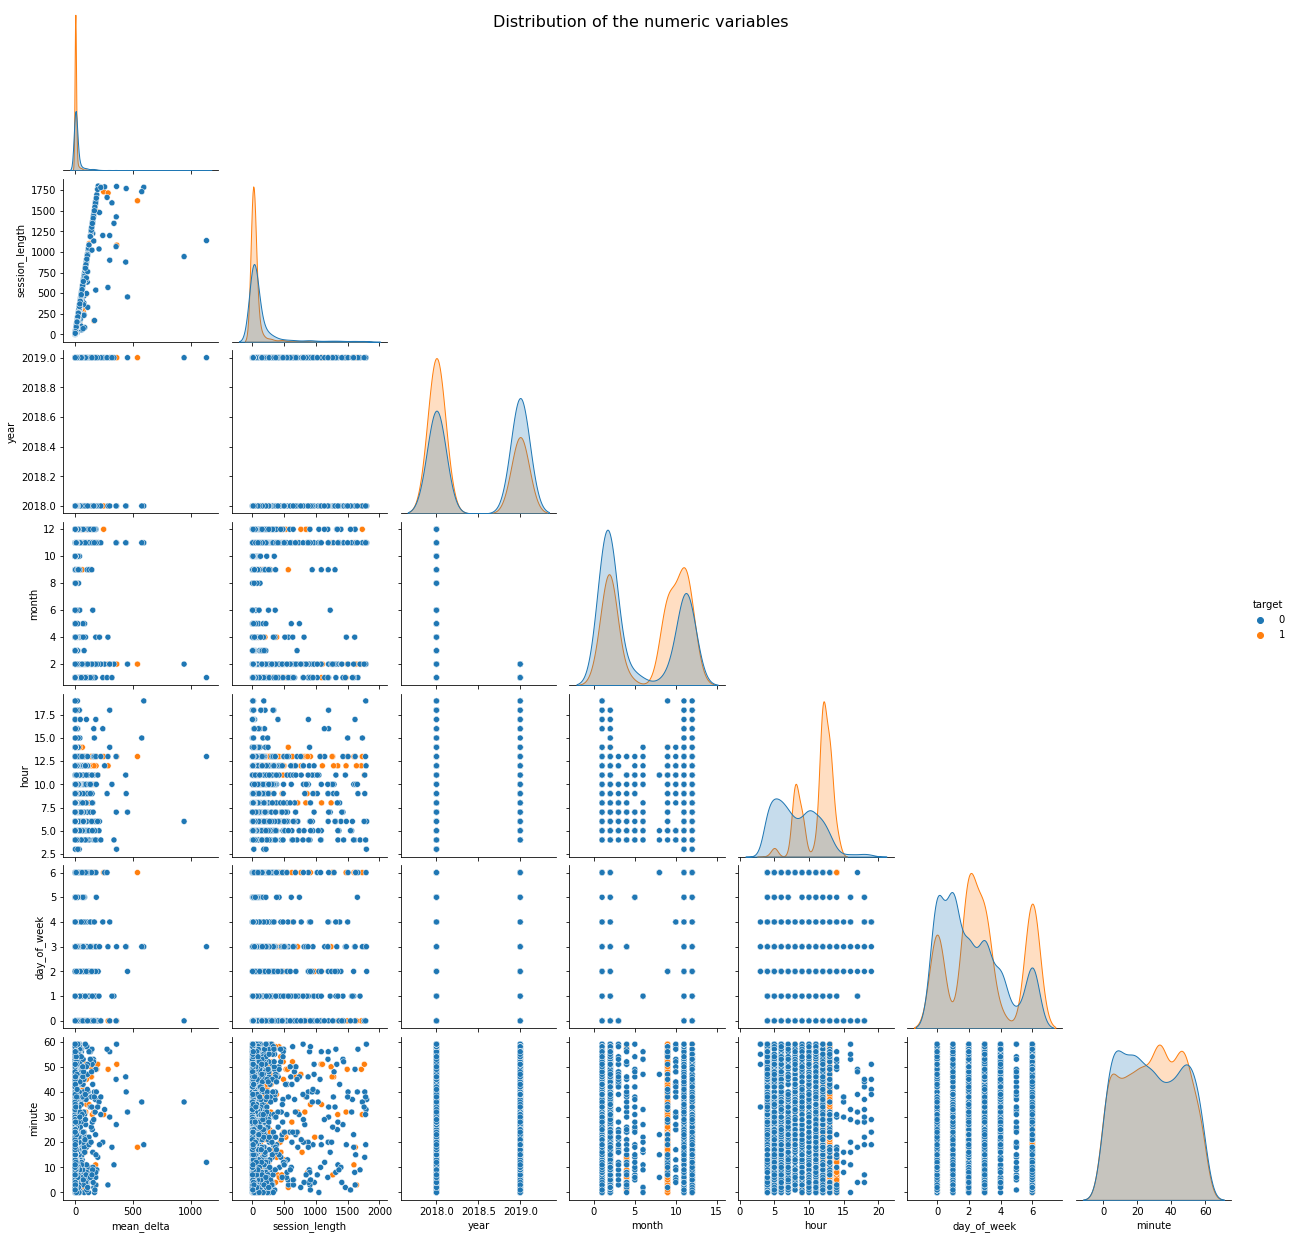

In [26]:
cols = ['mean_delta', 'session_length', 'year', 'month', 'hour', 'day_of_week', 'minute', 'target']
df_pos = df[df.target==1]
df_neg = df[df.target==0].sample(n=df_pos.shape[0], replace=False)
df_small = pd.concat([df_pos, df_neg])
sns.pairplot(df_small[cols], corner=True, hue='target')
plt.suptitle('Distribution of the numeric variables', fontsize=16)
plt.show()

# Modelling

## Model evaluation func

In [27]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, cv):

  scorers = {
              'f1_score': make_scorer(f1_score, average='micro'),
              'precision_score': make_scorer(precision_score, average='micro'),
              'recall_score': make_scorer(recall_score, average='micro'),
              'accuracy_score': make_scorer(accuracy_score)
            }

  results = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=cv, scoring='roc_auc', return_train_score=True, error_score="raise")

  ppl = pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)

  train_score = results['train_score']
  val_score = results['test_score']

  print(f'\nTrain roc_auc: {train_score.mean():.3f}, Std: {train_score.std():.3f}')
  print(f'Validation roc_auc: {val_score.mean():.3f}, Std: {val_score.std():.3f}')
  print(f'Test roc_auc: {roc_auc_score(y_test, y_pred):.3f}')

  print(classification_report(y_test, y_pred))

  return pipeline

## Preprocessor pipeline

In [28]:
cv = KFold(n_splits=3, random_state=1, shuffle=True)

df_pos = df[df.target==1]
df_neg = df[df.target==0].sample(n=df_pos.shape[0], replace=False)
df_small = pd.concat([df_pos, df_neg])
df_small = df_small.sample(frac = 1)

#scale_pos_weight = df[df.target==0].shape[0]/df[df.target==1].shape[0]
#scale_pos_weight = round(scale_pos_weight,1)

scale_pos_weight = df_small[df_small.target==0].shape[0]/df_small[df_small.target==1].shape[0]
scale_pos_weight = round(scale_pos_weight,1)

X = df_small.drop(['target'], axis=1)
y = df_small.target

#X = df.drop(['target'], axis=1)
#y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

#X_train.info()

In [29]:
print('Shape before the transformation:')
print(X_train.shape)
print(X_test.shape)

num_pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
])

text_pipeline1 = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('scale', MaxAbsScaler()),
])

text_pipeline2 = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('scale', MaxAbsScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
      ('num', num_pipeline, num_cols),
      ('text1', text_pipeline1, 'text'),
      ('text2', text_pipeline2, 'text2'),
    
])

pipeline = make_pipeline(
    preprocessor,
)


X_train_tr = pipeline.fit_transform(X_train, y_train)
X_test_tr = pipeline.transform(X_test)

print('Shape after the transformation:')
print(X_train_tr.shape)
print(X_test_tr.shape)

num_features = pipeline.named_steps['columntransformer'].transformers[0][2]
text_features_1 = pipeline.named_steps['columntransformer'].\
  transformers[1][1].named_steps['vectorizer'].fit(X_train['text']).\
  get_feature_names_out()
text_features_2 = pipeline.named_steps['columntransformer'].\
  transformers[2][1].named_steps['vectorizer'].fit(X_train['text2']).\
  get_feature_names_out()
feature_names = list(num_features) + list(text_features_1) + list(text_features_2)

Shape before the transformation:
(2520, 28)
(630, 28)
Shape after the transformation:
(2520, 14626)
(630, 14626)
['webpage1', 'webpage2', 'webpage3', 'webpage4', 'webpage5', 'webpage6', 'webpage7', 'webpage8', 'webpage9', 'webpage10', 'time_delta1', 'time_delta2', 'time_delta3', 'time_delta4', 'time_delta5', 'time_delta6', 'time_delta7', 'time_delta8', 'time_delta9', 'mean_delta', 'session_length', 'year', 'month', 'hour', 'minute', 'day_of_week']
['01' '01 10005' '01 10013' ... 'ztat net' 'zupimages' 'zupimages net']
['01' '01 fond' '1001modelkitscom' ... 'zupimagesnet acstanet'
 'zupimagesnet vkcom' 'zupimagesnet zupimagesnet']


NameError: ignored

## XGB

In [ ]:
%%time

def objective(space):
    params = {
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(space['learning_rate']),
        'alpha' : '{:.3f}'.format(space['alpha']),
        'n_estimators': space['n_estimators']
    }
    
    clf = XGBClassifier(
        objective ='binary:logistic',
        random_state=42,
        **params
    )

    ppl = make_pipeline(
        preprocessor,
        #SimpleImputer(),
        #over,
        clf,
    )    
    
    score = cross_val_score(ppl, X_train, y_train, scoring='roc_auc', cv=10).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'alpha': hp.uniform('alpha', 0, 10),
    'n_estimators': hp.choice('n_estimators', [100, 1000, 3000])
    }

#best = fmin(fn=objective,
#            space=space,
#            algo=tpe.suggest,
#            max_evals=10)

In [ ]:
#best

In [32]:
best_xg_clf = XGBClassifier(objective ='binary:logistic', 
                            alpha= 7.24,
                            colsample_bytree = 0.37,
                            learning_rate=0.67,
                            n_estimators=1000,
                            gamma=1.5, max_depth=6, min_child_weight=1,
                            scale_pos_weight = scale_pos_weight,
                            subsample=1.0,
                            )

ppl_xg = make_pipeline(
    preprocessor,
    best_xg_clf,
)   

ppl_xg = evaluate_model(ppl_xg, X_train, y_train, X_test, y_test, cv)


Train roc_auc: 0.996, Std: 0.001
Validation roc_auc: 0.974, Std: 0.001
Test roc_auc: 0.910
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       315
           1       0.88      0.95      0.91       315

    accuracy                           0.91       630
   macro avg       0.91      0.91      0.91       630
weighted avg       0.91      0.91      0.91       630



Let's try to get features from the pipeline

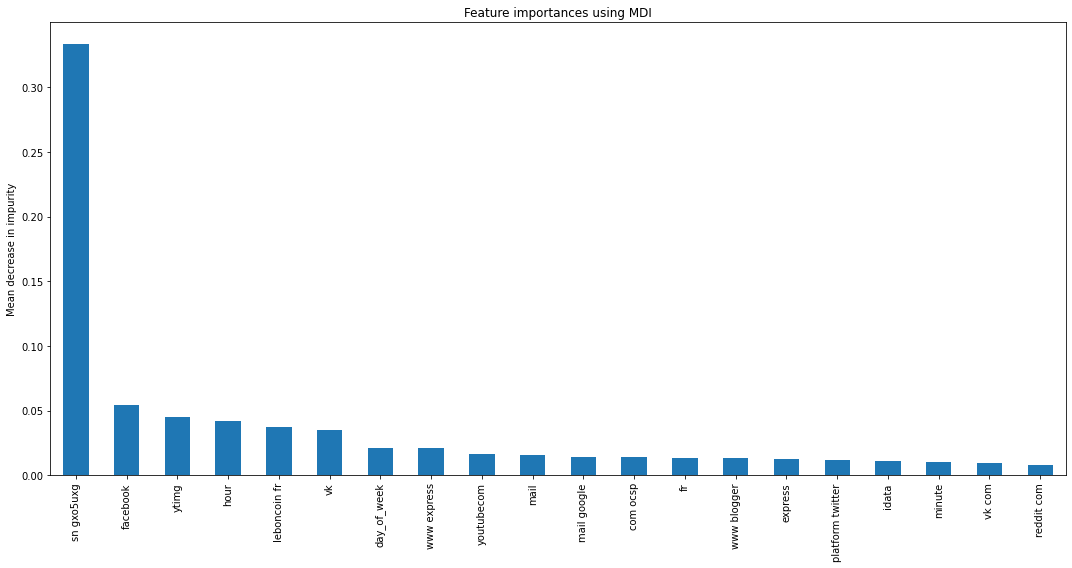

In [33]:
feature_importances = ppl_xg.named_steps['xgbclassifier'].feature_importances_
forest_importances = pd.Series(feature_importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.sort_values(ascending=False)[0:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

## LightGBM

In [ ]:
%%time

def objective(space):
    params = {
        'num_leaves': space['num_leaves'],
        'n_estimators': space['n_estimators']
    }
    
    clf = LGBMClassifier( 
        random_state=42,
        class_weight='balanced',
        **params
    )

    ppl = make_pipeline(
        preprocessor,
        #SimpleImputer(),
        #over,
        clf,
    )    
    
    score = cross_val_score(ppl, X_train, y_train, scoring='roc_auc', cv=10).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'num_leaves': hp.choice('num_leaves', [5,7,10,15,20,25,30,35,40,45]),
    'n_estimators': hp.choice('n_estimators', [100, 1000, 3000])
    }

#best = fmin(fn=objective,
#            space=space,
#            algo=tpe.suggest,
#            max_evals=10)

CPU times: user 157 µs, sys: 0 ns, total: 157 µs
Wall time: 161 µs


In [ ]:
#best

In [ ]:
best_lgbm_clf = LGBMClassifier(
                        n_estimators=1000,
                        class_weight='balanced', 
                        num_leaves=9
                        )


ppl_lg = make_pipeline(
    preprocessor,
    SimpleImputer(),
    SMOTE(),
    best_lgbm_clf,
)   

ppl_lg = evaluate_model(ppl_lg, X_train, y_train, X_test, y_test, cv)


Train roc_auc: 1.000, Std: 0.000
Validation roc_auc: 0.986, Std: 0.002
Test roc_auc: 0.949
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       315
           1       0.94      0.96      0.95       315

    accuracy                           0.95       630
   macro avg       0.95      0.95      0.95       630
weighted avg       0.95      0.95      0.95       630



## Catboost

In [ ]:
best_cat_clf = CatBoostClassifier( 
        verbose=False,
        scale_pos_weight = scale_pos_weight,
        iterations=251
    )

ppl_cat = make_pipeline(
    preprocessor,
    SimpleImputer(),
    SMOTE(),
    best_cat_clf,
)   

ppl_cat = evaluate_model(ppl_cat, X_train, y_train, X_test, y_test, cv)

#X_test_transformed = pipeline.transform(X_test)
#ppl.fit(X_train, y_train,
#       catboostclassifier__eval_set=(X_test_transformed, y_test), catboostclassifier__plot=True)


Train roc_auc: 0.999, Std: 0.000
Validation roc_auc: 0.985, Std: 0.003
Test roc_auc: 0.956
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       315
           1       0.94      0.97      0.96       315

    accuracy                           0.96       630
   macro avg       0.96      0.96      0.96       630
weighted avg       0.96      0.96      0.96       630



## Stacking

In [ ]:
# Prepare the list of tuples with the first-layer classifiers
classifiers = [
	('one', ppl_cat),
  ('two', ppl_lg),
  ('three', ppl_xg)
]

# Instantiate the second-layer meta estimator
clf_meta = LogisticRegression()

# Build the stacking classifier
clf_stack = StackingClassifier(
   estimators=classifiers,
   final_estimator=clf_meta,
   stack_method='predict_proba',
   passthrough=False)

clf_stack = evaluate_model(clf_stack, X_train, y_train, X_test, y_test, cv)


Train roc_auc: 1.000, Std: 0.000
Validation roc_auc: 0.988, Std: 0.002
Test roc_auc: 0.960
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       315
           1       0.96      0.96      0.96       315

    accuracy                           0.96       630
   macro avg       0.96      0.96      0.96       630
weighted avg       0.96      0.96      0.96       630



In [ ]:
clf_stack.fit(X, y)
y_proba_sub = clf_stack.predict_proba(df_sub)
submission_csv = pd.DataFrame({'session_id': df_sub.index, 'target': y_proba_sub[:,1]})
submission_csv.to_csv('submission.csv', index=False)